In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import scipy.optimize as sci_opt
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from client import PriceHistory
from fake_useragent import UserAgent

In [2]:
# Set some display options for Pandas.
pd.set_option('display.max_colwidth', -1)
pd.set_option('expand_frame_repr', False)

C:\Users\vasee\AppData\Local\Temp\ipykernel_16420\3998464097.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [3]:
price_df : pd.DataFrame = pd.read_csv(
          r'C:\Users\vasee\Desktop\portfolio opt\portfolio-optimization\data\stock_data.csv'
          )

In [4]:
price_df.head()

,date,close,volume,open,high,low,symbol
0,2023-04-21,106.96,86652650,106.10,108.15,105.08,AMZN
1,2023-04-20,103.81,57696870,103.53,105.25,103.21,AMZN
2,2023-04-19,104.30,58398890,101.58,105.12,101.39,AMZN
3,2023-04-18,102.30,39790520,103.95,104.20,101.52,AMZN
4,2023-04-17,102.74,39919460,103.16,103.73,101.59,AMZN


In [5]:
#Rearranging
price_df = price_df.pivot(index='date',
                          columns='symbol',
                          values='close')

In [6]:
price_df.head()

symbol,AAPL,AMZN,MSFT,SQ
date,,,,
2022-04-25,162.88,146.0740,280.72,107.38
2022-04-26,156.80,139.3910,270.22,100.47
2022-04-27,156.57,138.1670,283.22,99.93
2022-04-28,163.64,144.5965,289.63,104.64
2022-04-29,157.65,124.2815,277.52,99.54


In [7]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 2022-04-25 to 2023-04-21
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    250 non-null    float64
 1   AMZN    250 non-null    float64
 2   MSFT    250 non-null    float64
 3   SQ      250 non-null    float64
dtypes: float64(4)
memory usage: 9.8+ KB


<Axes: xlabel='date'>

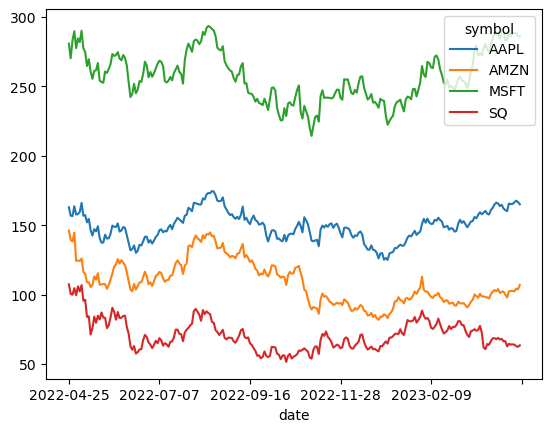

In [8]:
price_df.plot()

<Axes: xlabel='date'>

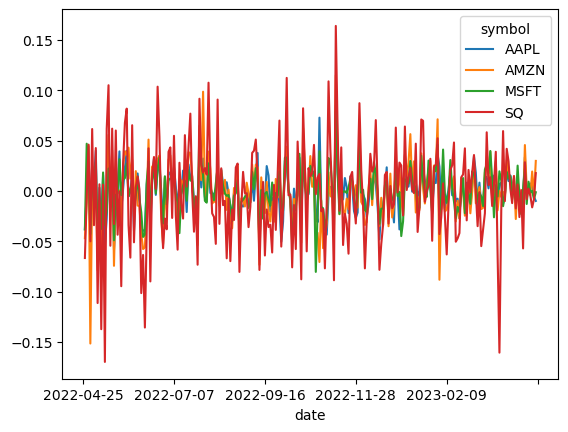

In [9]:
#taking log returns
log_ret = np.log(1+ price_df.pct_change())
log_ret.plot()

In [11]:
# Generate Random Weights.
random_weights = np.array(np.random.random(4))

# Rebalancing Weights
rebalance_weights = random_weights / np.sum(random_weights)

In [14]:
# Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_ret.mean() * rebalance_weights) * 252)
# Expected Volatility, annualize it 
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_ret.cov() * 252,
        rebalance_weights
    )
)
)

In [15]:
# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol


In [16]:
# Put the weights into a data frame
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)

metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)

PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0  0.788034        0.478887         
1  0.124069        0.075397         
2  0.577133        0.350722         
3  0.156319        0.094995         
PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0 -0.061674                    0.353919                      -0.17426               


# Monte Carlo

In [17]:
#define iteration
no_it = 5000

# array to store the weights
all_weights = np.zeros((no_it,4))

#array to store the returns 
ret_arr = np.zeros(no_it)

# array to store the volatilities 
vol_arr = np.zeros(no_it)

# array to store the sharpe ratios 
sharpe_arr = np.zeros(no_it)

In [18]:
# Starting simulations.
for ind in range(no_it):

    # calculate the weights.
    weights = np.array(np.random.random(4))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_ret.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_ret.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]


In [19]:
#create our Data Frame with the weights, the returns, the volatility, and the Sharpe Ratio
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

In [20]:
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)

SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio                                                                     Portfolio Weights
0 -0.175879  0.425819   -0.413038      [0.14190417762458885, 0.11198127082647014, 0.4627093210912795, 0.2834052304576615]  
1 -0.105510  0.385929   -0.273391      [0.2508801859729727, 0.035570611230919674, 0.512719528519241, 0.20082967427686677]  
2 -0.231245  0.468689   -0.493386      [0.3058533325706065, 0.10377668115879603, 0.2027559263957868, 0.38761405987481057]  
3 -0.185274  0.401017   -0.462011      [0.41071979536933795, 0.43098036962399394, 0.05354607396929662, 0.10475376103737151]
4 -0.177755  0.406599   -0.437176      [0.19576939827763734, 0.2826183238347587, 0.3387117659658092, 0.18290051192179482]  
--------------------------------------------------------------------------------


In [21]:
# Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

#Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns              0.003255                                                                           
Volatility           0.327937                                                                           
Sharpe Ratio         0.009924                                                                           
Portfolio Weights    [0.49151138925986826, 0.02794062617251453, 0.474948430470364, 0.005599554097253188]
Name: 3362, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns              0.003255                                                                           
Volatility           0.327937                                                                           
Sharpe Ratio         0.009924                                    

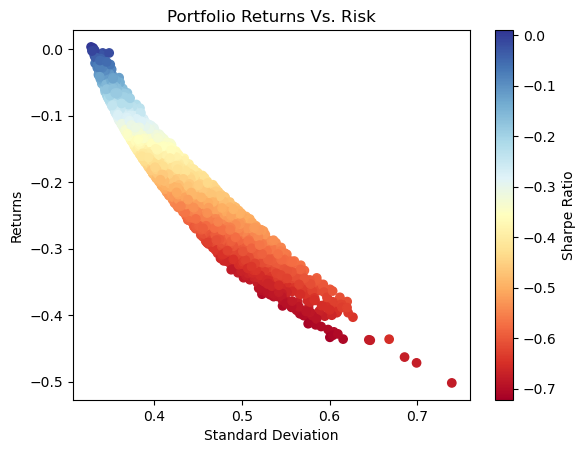

In [22]:
#plotting
%matplotlib inline
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

plt.show()

# SCipy Optimization

In [23]:
def get_metrics(weights: list) -> np.array:


    # Convert weights to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, and annualize
    ret = np.sum(log_ret.mean() * weights) * 252

    # Calculate the volatility, and annualize
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_ret.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

In [24]:
def grab_negative_sharpe(weights: list) -> np.array:
    return 1-get_metrics(weights)[2]

def grab_volatility(weights: list) -> np.array:

    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:

    return np.sum(weights) - 1


In [26]:
# Define the boundaries for each symbol
bounds = tuple((0, 1) for symbol in range(4))

# Define the constraint
constraints = ({'type': 'eq', 'fun': check_sum})

#create an initial guess to start with,
init_guess = 4 * [1 / 4]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, 
    method='SLSQP',
    bounds=bounds,
    constraints=constraints 
)

In [27]:
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)

OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.9476050175118337
       x: [ 0.000e+00  1.790e-15  1.000e+00  0.000e+00]
     nit: 6
     jac: [ 2.987e-03  9.727e-01 -0.000e+00  1.622e+00]
    nfev: 30
    njev: 6


In [29]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)

# Print the Optimized Metrics.

print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.00000000e+00 1.79023463e-15 1.00000000e+00 0.00000000e+00]
OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.01800896 0.34371533 0.05239498]


## For min volatility

In [30]:
optimized_volatility = sci_opt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)

OPTIMIZED VOLATILITY RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.3254721205896835
       x: [ 4.933e-01  1.171e-16  5.067e-01  0.000e+00]
     nit: 7
     jac: [ 3.255e-01  3.683e-01  3.255e-01  5.217e-01]
    nfev: 35
    njev: 7


In [31]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)


# Print the Optimized Metrics.
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)

OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[4.93347273e-01 1.17093835e-16 5.06652727e-01 0.00000000e+00]
OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.01564151 0.32547212 0.04805791]
